In [117]:
import pandas as pd
import numpy as np
import re
import pylab as plt
import copy
import math

In [22]:
def ReadStataDct(dct_file,filename):
    """Reads a Stata dictionary file.

    dct_file: string filename
    options: dict of options passed to open()

    returns: FixedWidthVariables object
    
    FROM Think Stats (A. Downey)
    """
    type_map = dict(byte=int, int=int, long=int, float=float, double=float)

    var_info = []
    for line in open(dct_file):
        match = re.search( r'_column\(([^)]*)\)', line)
        if match:
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pd.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    #dct = FixedWidthVariables(variables, index_base=1)
    colspecs = variables[['start', 'end']] - 1
    colspecs = colspecs.astype(np.int).values.tolist()
    names = variables['name']
    df = pd.read_fwf(filename,colspecs=colspecs,names=names)
    return df

Code from Think Stats, as exercise in chapter 13, examined survival curve of divorce in marriage from a different cycle of NSFG survey

In [202]:
df=ReadStataDct('2006_2010_FemRespSetup.dct','2006_2010_FemResp.dat')

Using 2006-2010 as it has the largest number of responses

In [77]:
df.describe()

,caseid,rscrninf,rscrage,rscrhisp,rscrrace,age_a,age_r,cmbirth,agescrn,marstat,...,secu,sest,cmintvw,cmlstyr,cmjan3yr,cmjan5yr,questyear,quarter,phase,intvlngth
count,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,...,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000
mean,33128.309309,2.798844,28.583598,4.155632,4.703722,28.635068,28.635068,953.114179,28.599479,3.736705,...,2.003991,135.988924,1302.753644,1290.753644,1261.509162,1237.509162,2.535386,8.668377,1.084046,81.455548
std,4679.506229,1.989939,8.410234,1.632401,1.039618,8.445265,8.445265,102.338992,8.444188,2.275133,...,1.031860,14.482793,14.213140,14.213140,15.062623,15.062623,1.128579,4.706620,0.277468,100.251288
min,26141.000000,1.000000,15.000000,1.000000,1.000000,15.000000,15.000000,740.000000,15.000000,1.000000,...,1.000000,101.000000,1278.000000,1266.000000,1237.000000,1213.000000,1.000000,1.000000,1.000000,15.600000
25%,29210.500000,1.000000,21.000000,5.000000,4.000000,21.000000,21.000000,869.000000,21.000000,1.000000,...,1.000000,126.000000,1290.000000,1278.000000,1249.000000,1225.000000,1.000000,4.000000,1.000000,52.940000
50%,32280.000000,1.000000,28.000000,5.000000,5.000000,28.000000,28.000000,959.000000,28.000000,4.000000,...,2.000000,140.000000,1303.000000,1291.000000,1261.000000,1237.000000,3.000000,9.000000,1.000000,68.350000
75%,36917.500000,5.000000,36.000000,5.000000,5.000000,36.000000,36.000000,1040.000000,36.000000,6.000000,...,3.000000,148.000000,1315.000000,1303.000000,1273.000000,1249.000000,4.000000,13.000000,1.000000,86.480000
max,42681.000000,5.000000,44.000000,5.000000,6.000000,45.000000,45.000000,1143.000000,44.000000,6.000000,...,4.000000,156.000000,1326.000000,1314.000000,1285.000000,1261.000000,4.000000,16.000000,2.000000,997.000000


In [78]:
df.columns

Index([u'caseid', u'rscrninf', u'rscrage', u'rscrhisp', u'rscrrace', u'age_a',
       u'age_r', u'cmbirth', u'agescrn', u'marstat',
       ...
       u'secu', u'sest', u'cmintvw', u'cmlstyr', u'cmjan3yr', u'cmjan5yr',
       u'questyear', u'quarter', u'phase', u'intvlngth'],
      dtype='object', length=3741)

Many columns, description for all in codebook https://www.icpsr.umich.edu/webdocs/Controller?displayPage=femaleResp

In [79]:
len(df[['divdathx_y','whmarhx_y']].dropna()),len(df[['divdathx_y','whmarhx_y','divdathx_m','whmarhx_m']].dropna())

(1574, 1574)

In [93]:
len(df[['divdathx_y','whmarhx_y','agemarhx']].dropna())

49

Thinking about later examining divorce rate grouped by age when married cohort, will loss a lot of data

In [350]:
totM = 0
totD = 0
for i in range(6):
    if i == 0:
        tmpD = float(len(df[(df['marendhx'] == 2) | (df['marendhx'] == 3)]))
        tmpM = float(len(df['whmarhx_y'].dropna()))
        print ('Frac of marriage 1 that end in divorce: '+str(tmpD/tmpM)+' +/- '+str(1/math.sqrt(tmpM)))
        totM += tmpM
        totD += tmpD
    else:
        tmpD = float(len(df[(df['marendhx'+str(i+1)] == 2) | (df['marendhx'+str(i+1)] == 3)]))
        tmpM = float(len(df['whmarhx_y'+str(i+1)].dropna()))
        print ('Frac of marriage '+str(i+1)+' that end in divorce: '+str(tmpD/tmpM)+' +/- '+str(1/math.sqrt(tmpM)))
        totM += tmpM
        totD += tmpD
print ('')
print ('Total frac of marriages that end in divorce: '+str(totD/totM)+' +/- '+str(math.sqrt(totD)/totM))

Frac of marriage 1 that end in divorce: 0.284269459996 +/- 0.0134388695483
Frac of marriage 2 that end in divorce: 0.321285140562 +/- 0.0365880866632
Frac of marriage 3 that end in divorce: 0.327586206897 +/- 0.0928476690885
Frac of marriage 4 that end in divorce: 0.384615384615 +/- 0.277350098113
Frac of marriage 5 that end in divorce: 0.4 +/- 0.4472135955
Frac of marriage 6 that end in divorce: 0.0 +/- 0.707106781187

Total frac of marriages that end in divorce: 0.289563862928 +/- 0.00671590689636


Accross the 2006-2010 database, ~29% of marriages have ended in divorce (w/ error of 0.7%, assuming Poisson noise)

Important caveat is that this is based off # of divorces so far (as of data taking) => this is a lower limit

It appears that divorce rate is consistent across marriage #, wonder if this is an artifact of these being lower limits, ie second and third marriages are more likely than first marriages to not have been given enough time to end in divorce at the time of being interviewed

In [208]:
def addMYdate_len(df):
    df['intvMY'] = (df.cmintvw - 1278.0)/12.0 + 2006.5
    df['cmarMY'] = (df.cmmarrch - 1278.0)/12.0 + 2006.5
    df['sofarLen'] = df.intvMY - df.cmarMY
    for i in range(6):
        if i > 0:
            col_name = ['whmarhx_y'+str(i+1),'whmarhx_m'+str(i+1),'divdathx_y'+str(i+1),'divdathx_m'+str(i+1)]
        else:
            col_name = ['whmarhx_y','whmarhx_m','divdathx_y','divdathx_m']
        tmp_month = copy.deepcopy(df[col_name[1]])
        tmp_month[tmp_month == 13] = 1.0
        tmp_month[tmp_month == 14] = 4.0
        tmp_month[tmp_month == 15] = 7.0
        tmp_month[tmp_month == 98] = 10.0
        tmp_month[(tmp_month == 98) | (tmp_month == 99)] = 6.0
        df['marMY'+str(i+1)] = df[col_name[0]] + tmp_month/12.0
        
        tmp_month = copy.deepcopy(df[col_name[3]])
        tmp_month[tmp_month == 13] = 1.0
        tmp_month[tmp_month == 14] = 4.0
        tmp_month[tmp_month == 15] = 7.0
        tmp_month[tmp_month == 16] = 10.0
        tmp_month[(tmp_month == 98) | (tmp_month == 99)] = 6.0
        df['divMY'+str(i+1)] = df[col_name[2]] + tmp_month/12.0
        
        tmp_marLen = df['divMY'+str(i+1)] - df['marMY'+str(i+1)]
        tmp_marLen[(tmp_marLen < 0) | (tmp_marLen > 1e2)] = 0
        df['marLen'+str(i+1)] = tmp_marLen

addMYdate_len(df)
df.marLen1.describe()

count    1574.000000
mean        6.230411
std         4.565948
min         0.000000
25%         2.833333
50%         5.250000
75%         8.583333
max        27.000000
Name: marLen1, dtype: float64

In [217]:
df[['sofarLen','marLen1','marLen2','marLen3','marLen4','marLen5']].dropna()

,sofarLen,marLen1,marLen2,marLen3,marLen4,marLen5
6031,4.916667,7.00,0.583333,1.000000,3.0,0.25
11628,4.916667,2.25,0.166667,1.416667,0.0,0.00


Quick test that there is no overlap in sofarLen and any marLen param, that is current marriages are not being counted in the divorce metrics

Examining the codebook, there are 2 respondants who entered into a 6th marriage and where not divorced at the time of being interviewed

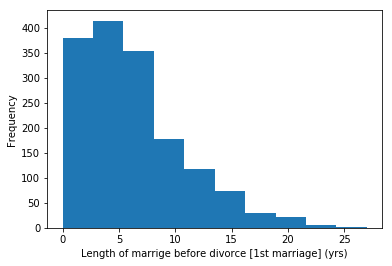

In [218]:
plt.hist(df['marLen1'].dropna())
plt.xlabel('Length of marrige before divorce [1st marriage] (yrs)')
plt.ylabel('Frequency')

In [243]:
def divMarArray(df):
    #use_df = df[df.evrmarry == 1]
    #all_mlen = np.array(use_df[use_df.whmarhx_y>0].marLen1)
    all_mlen = np.array(df.marLen1.dropna())
    for i in range(5):
        #tmp_array = np.array(use_df[use_df['whmarhx_y'+str(i+2)] > 0]['marLen'+str(i+2)])
        tmp_array = np.array(df['marLen'+str(i+2)].dropna())
        all_mlen = np.append(all_mlen,tmp_array)
    
    sf_len = np.array(df.sofarLen.dropna())
    return all_mlen, sf_len
mlen, sflen = divMarArray(df)
len(sflen),len(mlen)

(5537, 1859)

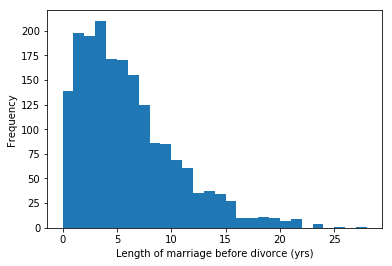

In [244]:
bins = range(int(np.nanmax(mlen)+2))
hist,bins, junk = plt.hist(mlen[np.isfinite(mlen)],bins=bins)
plt.xlabel('Length of marriage before divorce (yrs)')
plt.ylabel('Frequency')

5 year itch, not so much, closer to 4 year itch, as demonstrated with the peak in the distribution

In [301]:
def divFraclen(len_arr,sf_arr):
    tot_len = len(len_arr)
    tot_sti = len(sf_arr)
    years = np.array(range(int(np.nanmax(len_arr)+1)))+1.0
    divFrac = np.zeros(len(years))
    low_est = np.zeros(len(years))
    giv_est = np.zeros(len(years))
    
    #use_arr = len_arr[np.isfinite(len_arr)]
    for i in range(len(years)):
        #num_div = len(np.where((use_arr >= 0) & (use_arr < years[i]))[0])
        num_div = len(np.where((len_arr >= 0) & (len_arr < years[i]))[0])
        num_mar = len(np.where(sf_arr >= years[i])[0])
        divFrac[i] = float(num_div) / (tot_len + num_mar)
        low_est[i] = float(num_div) / (tot_len + tot_sti)
        if i == 0:
            giv_est[i] = float(num_div) / (tot_len + tot_sti)
        else:
            giv_est[i] = (num_div + (giv_est[i-1])*(tot_sti-num_mar)) / (tot_len + tot_sti)
    return years, divFrac, low_est, giv_est
yrs,frac,lowe,d_est = divFraclen(mlen,sflen)

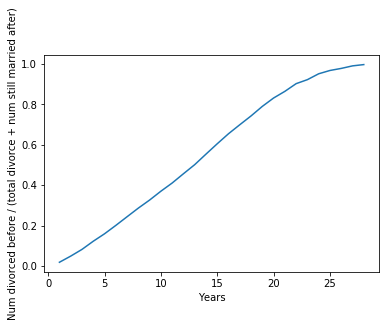

In [303]:
plt.plot(yrs,frac,label='Marr < t not incl')
#plt.plot(yrs,lowe,label='All marr stay marr')
#plt.plot(yrs,d_est,label='Estimation')
plt.xlabel('Years')
#plt.legend()
plt.ylabel('Num divorced before / (total divorce + num still married after)')

Ratio is the number of marriages that have ended in divorce before a specific time (independent variable) divided by the total of two numbers: all marriages that ended in divorce at any time and marriages that are on-going that have lasted at least as long as specific time (independent variable)

There is another group: those who are still married but have been married for less time than specified time t (independent variable), currently this group is not included in calculation and as result, the above fraction -> 1

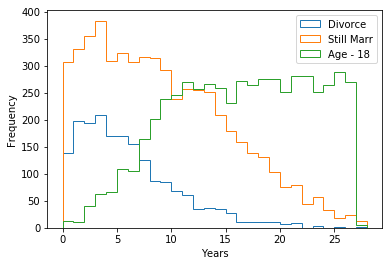

In [308]:
bins = range(int(np.nanmax(mlen)+2))
histD,bins,junk = plt.hist(mlen,bins=bins,histtype='step',label='Divorce')
histM,bins,junk = plt.hist(sflen,bins=bins,histtype='step',label='Still Marr')
hist,bins,junk = plt.hist(df[df.evrmarry==1].age_r-18,bins=bins,histtype='step',label='Age - 18')
plt.legend()
plt.xlabel('Years')
plt.ylabel('Frequency')

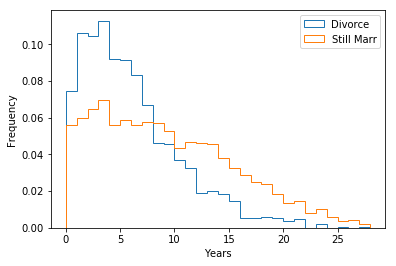

In [307]:
bins = range(int(np.nanmax(mlen)+2))
histD,bins,junk = plt.hist(mlen,bins=bins,histtype='step',label='Divorce',normed=1)
histM,bins,junk = plt.hist(sflen,bins=bins,histtype='step',label='Still Marr',normed=1)
#hist,bins,junk = plt.hist(df[df.evrmarry==1].age_r-18,bins=bins,histtype='step',label='Age - 18')
plt.legend()
plt.xlabel('Years')
plt.ylabel('Frequency')

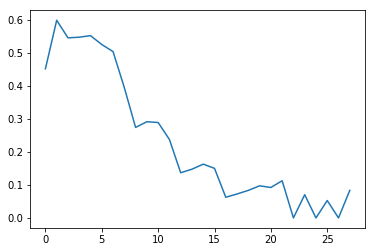

In [305]:
plt.plot(histD/histM)

Frequency in age (of those ever married) flattens out at ~30 yrs

In [278]:
df[df.evrmarry==1].age_r.describe()

count    5534.000000
mean       33.982472
std         6.389113
min        17.000000
25%        29.000000
50%        34.000000
75%        39.000000
max        45.000000
Name: age_r, dtype: float64

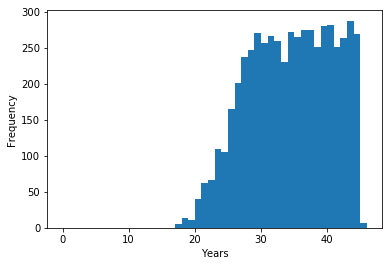

In [275]:
bins = range(int(df.age_r.max()+2))
plt.hist(df[df.evrmarry==1].age_r,bins=bins)
plt.xlabel('Years')
plt.ylabel('Frequency')

In [380]:
def estDiv(d_arr,sm_arr):
    years = np.array(range(int(np.max(d_arr)+2)))
    est_d = np.zeros(len(years)-1)
    est_m = np.zeros(len(years)-1)
    rate_d = np.zeros(len(years)-1)
    known_d = np.zeros(len(years)-1)
    d_error = np.zeros(len(years)-1)
    for i in range(len(years)-1):
        dm_tot = len(np.where(d_arr >= years[i])[0]) + len(np.where(sm_arr >= years[i])[0])
        known_d[i] = len(np.where((d_arr >= years[i]) & (d_arr < years[i+1]))[0])
        dm_ukn = len(np.where((sm_arr >= years[i]) & (sm_arr < years[i+1]))[0])
        if i > 0:
            dm_ukn += est_m[i-1]
            dm_tot += est_m[i-1]
        
        rate_d[i] = float(known_d[i]) / (dm_tot - dm_ukn)
        est_d[i] = rate_d[i] * dm_ukn
        est_m[i] = (1.0 - rate_d[i]) * dm_ukn
        d_error[i] = known_d[i]**2*dm_tot**2*dm_ukn/(dm_tot - dm_ukn)**4 + dm_ukn**2*known_d[i]/(dm_tot - dm_ukn)**2
        d_error[i] += dm_ukn**2*known_d[i]**2*dm_tot/(dm_tot - dm_ukn)**4

    d_error = np.sqrt(d_error)
    cumu_d = np.array([np.sum(known_d[:i+1])+np.sum(est_d[:i+1]) for i in range(len(est_d))])
    cumu_e = np.array([math.sqrt(np.sum(d_error[:i+1]**2) + np.sum(known_d[:i+1])) for i in range(len(est_d))])
    return est_d,rate_d,years[1:],cumu_d,d_error,cumu_e
est_d,rate_d,yrs,cumud,d_error,cumue = estDiv(mlen,sflen)

In [381]:
1.0 - np.prod(1.0-rate_d),cumue[-1]/(len(mlen)+len(sflen))

(0.57740991756482485, 0.85858633286985098)

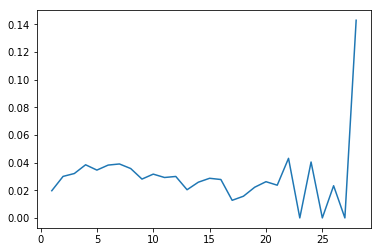

In [398]:
plt.plot(yrs,rate_d)

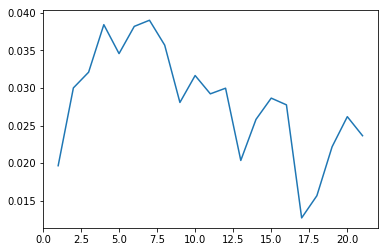

In [395]:
plt.plot(yrs[:21],rate_d[:21])

Maybe there is some wisdom in the 7 year itch instead. As previously observed, the largest number of divorces happen within the 4th year of marriage, the 7th year of marriage has the largest yearly percentage of divorces (ie the fraction of those still married at the beginning of year N will divorce by the end of year N)

In [401]:
1.0 - np.prod(1.0-rate_d[:21]),cumue[20]/(len(mlen)+len(sflen))

(0.45031595027244609, 0.012912564315836041)

(0, 0.5)

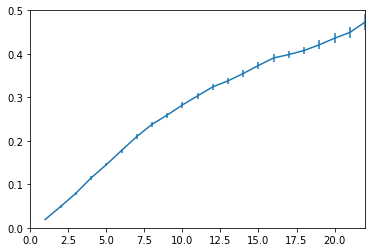

In [397]:
plt.errorbar(yrs,cumud/(len(mlen)+len(sflen)),yerr=cumue/(len(mlen)+len(sflen)))
plt.xlim([0,22])
plt.ylim([0,0.5])